# Hurricane Detection Heatmap Generation Prototyping


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
% matplotlib inline
import os
import time
from train_detection_cnn import build_detection_CNN

In [2]:
'''select which dataset to use'''
DATA_CHOICE = ['2channel', '3channel'][1]

if DATA_CHOICE == '2channel':
    work_dir = 'detection_cnn_lr_2ch/'
    data_dir = 'heatmap_data'
    input_file_name = 'hurricane_heatmap_input_2channels.npy'
    ckpt_file = 'model/model_1/model_1'
    window = 10    
elif DATA_CHOICE == '3channel':
    work_dir = 'detection_cnn_hr_3ch/'
    data_dir = 'heatmap_data'
    input_file_name = 'hurricane_heatmap_input_3channels.npy'
    ckpt_file = 'model/model_1/model_1'
    window = 40    
else:
    raise ValueError

path_to_data = os.path.join(work_dir, data_dir)
input_file = os.path.join(work_dir, data_dir, input_file_name)
ckpt_file = os.path.join(work_dir, ckpt_file)
print(work_dir)
print(path_to_data)
print(input_file)
print(ckpt_file)

detection_cnn_hr_3ch/
detection_cnn_hr_3ch/heatmap_data
detection_cnn_hr_3ch/heatmap_data/hurricane_heatmap_input_3channels.npy
detection_cnn_hr_3ch/model/model_1/model_1


(12577, 511, 1152, 3)


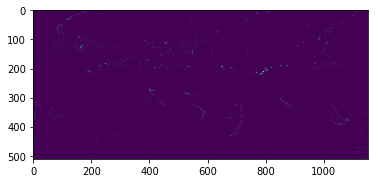

In [3]:
img = np.load(input_file, mmap_mode='r')  # time, lat, lon, chan
print(img.shape)
_, imgd2, imgd3, imgd4 = img.shape
plt.imshow(img[0,:,:,0])

## loading model

In [4]:
saver = tf.train.import_meta_graph(ckpt_file+'.meta')
sess = tf.Session()
saver.restore(sess, ckpt_file)

'''placeholders for conv'''
img_input = tf.get_collection('img_input')[0]
pred_y_map = tf.get_collection('pred_y_map')[0]
keep_prob = tf.get_collection('keep_prob')[0]

'''placeholders for sliding window'''
input_x = tf.get_collection('crop_input')[0]
pred_y = tf.get_collection('crop_pred')[0]

INFO:tensorflow:Restoring parameters from detection_cnn_hr_3ch/model/model_1/model_1


## Sliding window

In [5]:
_, n_lat, n_lon, _ = img.shape

In [6]:
win_size = window
img_idx = 777
offset = int(win_size/2)
time_s = time.time()
result_map = np.zeros((n_lat, n_lon))
for lat_idx in range(n_lat-win_size):
    for lon_idx in range(n_lon-win_size):
        window_crop = img[img_idx:img_idx+1, lat_idx:lat_idx+win_size, lon_idx:lon_idx+win_size, :]
        out = sess.run(pred_y, feed_dict={input_x: window_crop,
                                          keep_prob: 1.0})
        result_map[lat_idx + offset, lon_idx + offset] = out[0]
elapsed = time.time() - time_s
print('{:.3f}'.format(elapsed))

556.097


In [29]:
'''thresholding'''
result_map_thres = result_map.copy()
result_map_thres[result_map_thres <= 0.8] = 0.

In [27]:
'''load true hurricane position'''
output=np.load(os.path.join(work_dir, data_dir, 'hurricane_heatmap_location_lonlat.npy'))
index=777
inn=img[index,:,:,1]

d1,d2=np.shape(inn)

lat_resol=120.0/d1; lon_resol=360.0/d2;
print(lat_resol,lon_resol)

l_true_label = []

for k in range(len(output[index])):
    lat_index=(40.0+float((output[index][k].split(",")[1]).split(")")[0]))/lat_resol;
    lon_index=float((output[index][k].split(",")[0]).split("(")[1])/lon_resol;
    l_true_label.append((lon_index, lat_index))
    print(str(k)+" (lon,lat) :",output[index][k])
    print(str(k)+" (lon_index, lat_index) :",lon_index, lat_index)

0.9375 1.25
0 (lon,lat) : (134.685066,34.547997)
0 (lon_index, lat_index) : 107.74805280000001 79.51786346666668
1 (lon,lat) : (128.729447,20.853316)
1 (lon_index, lat_index) : 102.9835576 64.91020373333333
2 (lon,lat) : (247.805787,16.149786)
2 (lon_index, lat_index) : 198.2446296 59.893105066666664


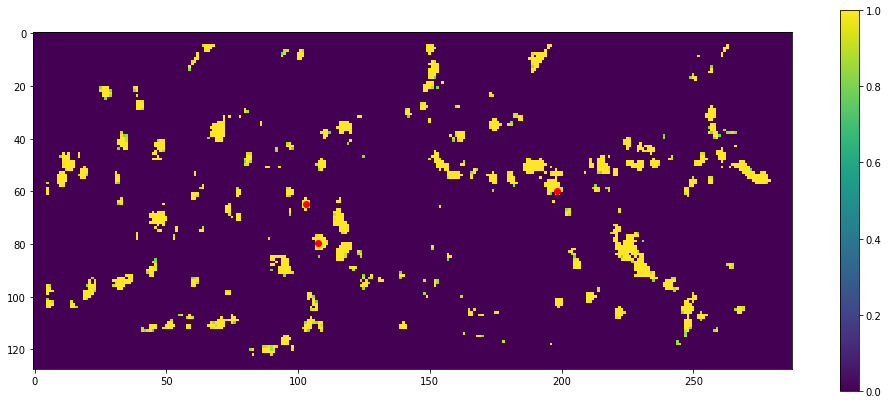

In [30]:
plt.figure(figsize=(17,7))
plt.imshow(result_map_thres[:,:])
plt.colorbar()

for t in l_true_label:
    plt.scatter([t[0]], [t[1]], c='r')

## CONV

In [13]:
# pred_img = sess.run(pred_y_map, feed_dict= {img_input:img[[400]], keep_prob:1})

In [14]:
# plt.figure(figsize=(16,9))
# plt.imshow(pred_img[0,:,:,0])
# plt.colorbar()